# Building Autoencoders in Keras

## What are auto encoders?

Auto encoders are used as compression and decompression algorithms which are learned from data instead of engineered.

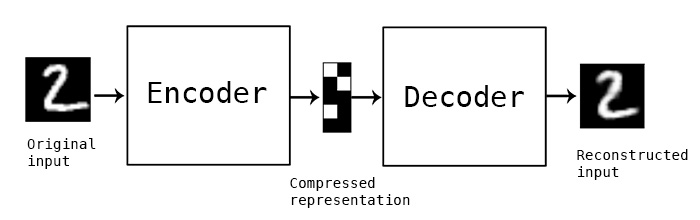

In [1]:
from IPython.display import Image
Image('https://blog.keras.io/img/ae/autoencoder_schema.jpg')

# Let's build the simplest autoencoder possible

In [2]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model

# this is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

Using TensorFlow backend.


Let's create a separate encoder model

In [0]:
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

And a decoder model

In [0]:
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

We will use a per-pixel binary crossentropy loss, which is generally used for binary classification.

In [0]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

Load the MNIST data set, and discard the labels since we're only interested in encoding/decoding the images.

In [6]:
from keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()

11493376/11490434 [==============================] - 1s 0us/step


Show an example of an image in the data set

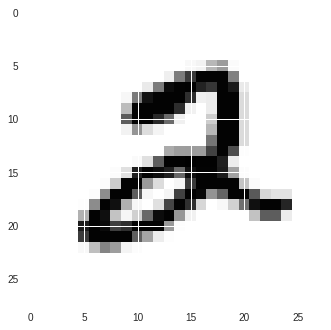

In [7]:
import matplotlib.pyplot as plt
plt.imshow(x_train[5, :, :])

Normalize the training data to values between 0 and 1, and flatten the images into vectors of size 784.

In [8]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


Lets train the encoder for 50 epochs (50 sweeps over the complete training set.)

In [9]:
history = autoencoder.fit(x_train, x_train, epochs=50, batch_size=256, shuffle=True,
                          validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 3s 52us/step - loss: 0.3726 - val_loss: 0.2700
Epoch 2/50
60000/60000 [==============================] - 1s 22us/step - loss: 0.2620 - val_loss: 0.2510
Epoch 3/50
60000/60000 [==============================] - 1s 22us/step - loss: 0.2428 - val_loss: 0.2315
Epoch 4/50
60000/60000 [==============================] - 1s 22us/step - loss: 0.2247 - val_loss: 0.2149
Epoch 5/50
60000/60000 [==============================] - 1s 22us/step - loss: 0.2101 - val_loss: 0.2025
Epoch 6/50
60000/60000 [==============================] - 1s 22us/step - loss: 0.1993 - val_loss: 0.1933
Epoch 7/50
60000/60000 [==============================] - 1s 22us/step - loss: 0.1912 - val_loss: 0.1863
Epoch 8/50
60000/60000 [==============================] - 1s 22us/step - loss: 0.1846 - val_loss: 0.1800
Epoch 9/50
60000/60000 [==============================] - 1s 22us/step - loss: 0.1785 - val_loss: 0.1742
Epoch

Make a plot of the convergence history of the training 

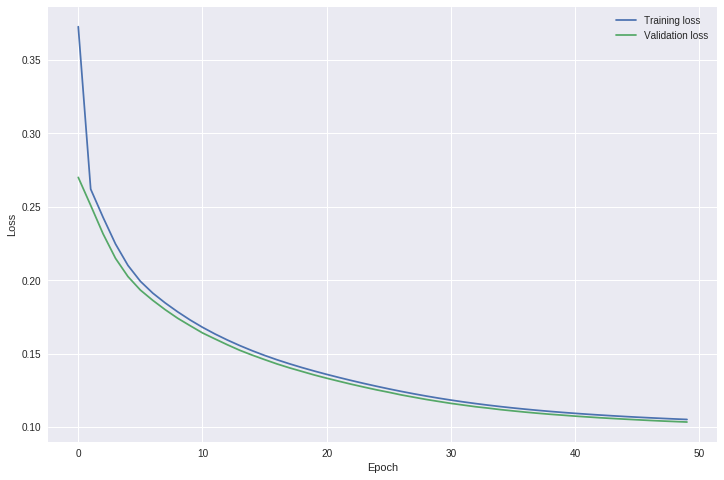

In [10]:
plt.figure(figsize=(12,8))
plt.plot(history.history['loss'], label="Training loss")
plt.plot(history.history['val_loss'], label="Validation loss")
plt.grid("on")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

The training loss and validation loss are starting to flatten out, indicating that the model is close to convergence. We can visualize the reconstructed inputs with the encoder and decoder network.

In [0]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

As shown in the figure, we are losing quite some detail with this basic approach.

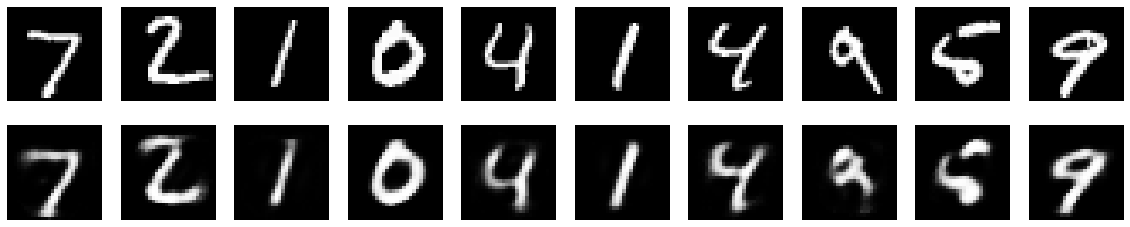

In [12]:
def plot_digits(n, x_test, decoded_imgs):
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

plot_digits(n=10, x_test=x_test, decoded_imgs=decoded_imgs)

# Deep autoencoder

We do not have to limit ourselves to single layers as encoders and decoders. We can add more layers as follows:

In [0]:
input_img = Input(shape=(784,))
encoded = Dense(128, activation='relu')(input_img)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(32, activation='relu')(encoded)

decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(784, activation='sigmoid')(decoded)

Lets train the new model. We are now training for 100 epochs which results in a longer training time.

In [14]:
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

history = autoencoder.fit(x_train, x_train, epochs=100, batch_size=256, shuffle=True,
                          validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 2s 41us/step - loss: 0.3556 - val_loss: 0.2645
Epoch 2/100
60000/60000 [==============================] - 2s 35us/step - loss: 0.2578 - val_loss: 0.2513
Epoch 3/100
60000/60000 [==============================] - 2s 34us/step - loss: 0.2394 - val_loss: 0.2297
Epoch 4/100
60000/60000 [==============================] - 2s 33us/step - loss: 0.2266 - val_loss: 0.2217
Epoch 5/100
60000/60000 [==============================] - 2s 34us/step - loss: 0.2182 - val_loss: 0.2095
Epoch 6/100
60000/60000 [==============================] - 2s 34us/step - loss: 0.2009 - val_loss: 0.1937
Epoch 7/100
60000/60000 [==============================] - 2s 34us/step - loss: 0.1891 - val_loss: 0.1853
Epoch 8/100
60000/60000 [==============================] - 2s 33us/step - loss: 0.1811 - val_loss: 0.1761
Epoch 9/100
60000/60000 [==============================] - 2s 34us/step - loss: 0.1748 - val_loss: 0.1

Review the convergence history again to make sure that the model is converged and is not overfitting the data.

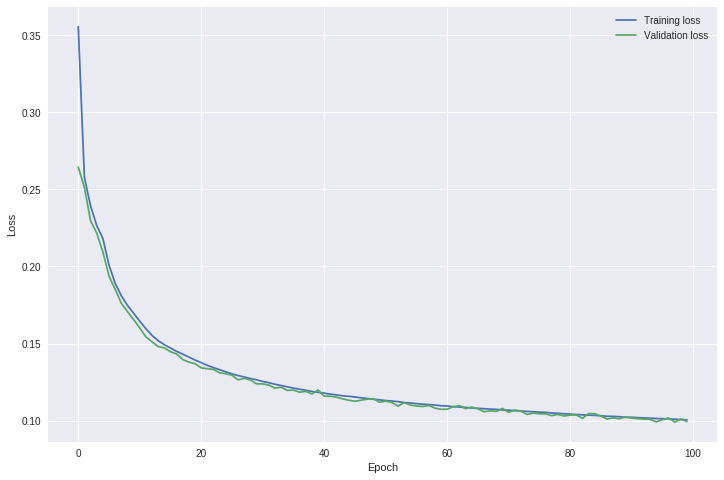

In [15]:
plt.figure(figsize=(12,8))
plt.plot(history.history['loss'], label="Training loss")
plt.plot(history.history['val_loss'], label="Validation loss")
plt.grid("on")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

The final loss is around 0.097, slightly better than our previous approach. Let's review the images.

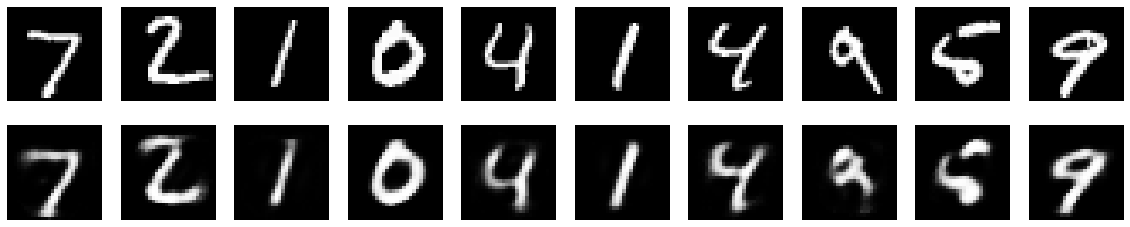

In [16]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

plot_digits(n=10, x_test=x_test, decoded_imgs=decoded_imgs)

# Application to image denoising

Let's train a new network which is able to remove noise from images. We simply add artificial noise to the training images.

In [0]:
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

Let's review the noisy images.

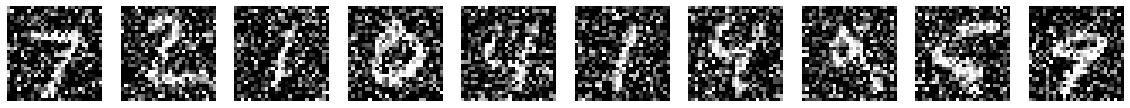

In [18]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

Can our encoder remove this noise?

In [0]:
input_img = Input(shape=(28, 28, 1))

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (7, 7, 32)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

Training again.

In [20]:
autoencoder.fit(x_train_noisy, x_train, epochs=2, batch_size=128, shuffle=True, validation_data=(x_test_noisy, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 9s 152us/step - loss: 0.1777 - val_loss: 0.1217
Epoch 2/2
60000/60000 [==============================] - 7s 120us/step - loss: 0.1190 - val_loss: 0.1124


Finally review the result.

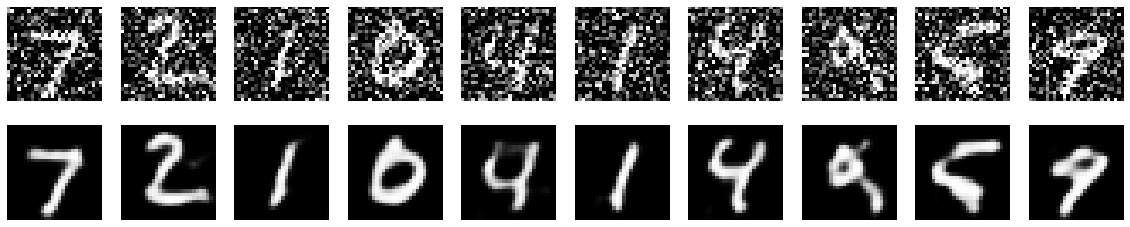

In [21]:
decoded_imgs = autoencoder.predict(x_test_noisy)

plot_digits(n=10, x_test=x_test_noisy, decoded_imgs=decoded_imgs)